# Analysis of simple and twisted interactions

This notebook consists of two main parts: *Data preparation* and *Data analysis*. The first provides information about the source of the data, all preprocessing steps and where to download annotation files and precomputed interaction files. The second part contains one section for each script. Each section provides a brief description of the analysis, cells that can be executed to perform the analysis on individual datasets as well as tables and plots for the reults.

## Data preparation


### Data sources

We analyzed datasets from the following pulications:

1. [Nora et al. 2017](https://www.ncbi.nlm.nih.gov/pubmed/28525758), mouse embryonic stem cells, Hi-C, HindIII
2. [Mifsud et al. 2015](https://www.ncbi.nlm.nih.gov/pubmed/25938943), human GM12878 and CD34+ blood cells, promoter capture Hi-C, HindIII
3. [Schoenefelder et al. 2015](https://www.ncbi.nlm.nih.gov/pubmed/25752748), mouse embryonic stem cells, promoter capture Hi-C, HindIII
4. [Chesi et al. 2019](https://www.ncbi.nlm.nih.gov/pubmed/30890710), human BMP2 induced osteoblasts and liver carcinoma HepG2 cells, Capture-C, DpnII

Paired-end reads were downloaded from the European Nucleotide Archive ([ENA](https://www.ebi.ac.uk/ena)) using the command line utility program ```wget```. Paired-end FASTQ files from ENA are in sync and can be processed directly.

### Trucation, mapping and counting of read pairs with Diachromatic

We used our Java application ```Diachromatic``` in order to derive read pair counts for interacting pairs of restriction digests. Source code and binaries are available on [GitHub](https://github.com/TheJacksonLaboratory/diachromatic) and documantation on [Read the Docs](https://diachromatic.readthedocs.io/en/latest/). Furthermore, a [recently published review article](https://www.mdpi.com/2073-4425/10/7/548) gives some application examples of ```Diachromatic```. We chose appropriate genome builds and restriction enzymes and default parameters otherwise with one exception. For the data of Chesi et al., we used the ```--sticky-end``` option for truncation because, for Capture-C, no fill-in of sticky ends is performed.

### Digest map preparation using GOPHER

```Diachromatic``` expects a *digest map* for the corresponding genome build and restriction enzyme as input. A *digest map* is a text file in which each line corresponds to restriction digest in the genome. The following line gives one example.
```
chr1    15172   15749   14      DpnII   DpnII   578     0.272   0.272   0.157   0.000   F       0       0
```
The first three columns contain the coordinates of a DpnII restriction digest of on chromosome 1. We used our Java application [GOPHER](https://www.ncbi.nlm.nih.gov/pubmed/30642251/) in order to prepare *digest maps* for mouse and human with DpnII or HindIII.

GOPHER flags digests that were selected for target enrichment as *selected* or *active* which is indicated by an F or T (FALSE or TRUE) in column 12. This information is used in ```Diachromatic``` to derive a quality metric that reflects the efficiency of target enrichment. Furthermore, the states (inactive/active) of digests are passed through the reported interactions. For the promoter capture Hi-C and Capture-C datasets, we used the preset option *All protein-coding genes* in order to flag all digests that overlap a transcription start site (TSS) of a protein-coding gene as *active*. For the CTCF depletion data, we manually prepared a digest map in which all digests that overlap predic TAD boundary that was *gone* upon CTCF depletion are selected.

### Diachromatic interaction files

All analyses presented here are based on Diachromatic interaction files in which each line represents one interaction. For instance, the line
```
chr5	156958482	156963927	A	chr5	157097590	157104795	I	0:2
```
represents an interaction between two restriction digests on chromosome 5. The first digest is flagged as active (A) and the second digest as inactive (I). The last column contains the number of simple and twisted read pairs for the given interaction separated by a colon. For the example above, there were no simple and two twisted read pairs.

Interactions with only one read pairs are not informative when analyzing shifts between simple and twisted read pairs. Therefore, all analyses presented here were performed on interactions with more than one read pair only (gt1 stands for greater than 1).

### UCSC's refGene.txt.gz file

The RefSeq annotation of TSS for ```mm10``` and ```hg38``` were taken from UCSC's ```refGene.txt.gz``` file. This file is used for various analysis steps including:

1. Preparation of a *digest map* as input for Diachromatic using GOPHER
2. TSS strand analysis
3. Expression analysis

It is important to use the same version of the ```refGene.txt.gz``` file for the different analysis steps in order to avoid inconsistencies due to changes of annotations.


### GTF input file for Tophat/Cufflinks

The GTF files that were used as input for Tophat and Cuffdiff were derived from the ```refGene.txt.gz``` file that was also used for the prepartion of the *digest map* as follows:

```shell
gzip -d refGene.txt.gz
cut -f 2- refGene.txt > refGene.input
genePredToGtf file refGene.input hg38refGene.gtf
cat hg38refGene.gtf  | sort -k1,1 -k4,4n > hg38refGene.gtf.sorted
```

### Calculation of FPKM values for known genes using Tophat and Cufflinks

This analysis was performed following the instructions given in [Trapnell et al. 2014](https://www.ncbi.nlm.nih.gov/pubmed/22383036).

### Download precalculated data from Owncloud

Precalculated files for interactions with more than one read pair (gt1), TSS annotation and FPKM values can be downloaded from [Owncloud](https://owncloud-ext.charite.de/owncloud/index.php/s/A0JPPRt8v9LCSVK). All files are packed within the file ```diascripts_data```. Unzip this file to your cloned diachscripts directory. For instance, by executing the following command:

```shell
unzip diachrscripts_data.zip -d /Users/hansep/PycharmProjects/diachrscripts/
```

This will create a directory ```diachrscripts_data``` with the following structure:

* nora_2017_mm9
* mifsud_2015_hg38
    * data
        * annotation
            * hg38_chromInfo.txt (**file containg chromosome sizes**)
            * hg38_gopher_refGene.txt (**UCSC's refGen file**)
            * hg38_gopher_refGene.gtf.sorted.gz (**refGen file converted to GTF format**)
            * mifsud_all_promoters_hg38_HindIII_DigestedGenome.txt.gz (**digest map**)
        * gzdir
            * MIFSUD_R10.interaction.counts.table.gt1.tsv.gz (**gt1 interactions for replicate 1**)
            * MIFSUD_R20.interaction.counts.table.gt1.tsv.gz (**gt1 interactions for replicate 2**)
            * MIFSUD_R30.interaction.counts.table.gt1.tsv.gz (**gt1 interactions for replicate 3**)
    * qc (**Diachromatic's quality reports for truncation and mapping**)
    * results (*** results precalculated with this Jupyter notebook***)
* schoenefelder_2015_mm10
* chesi_2019_hg38

## Data analysis

### Preparations

The execution of the scripts assume the directory structure given above.
So far, we use ```pandas``` data frames.
Use ```autoreload``` if you plan to edit and excute the scripts alternately, otherwise your changes will not become effective in this notebook.

In [7]:
import pandas as pd
%load_ext autoreload
%autoreload 2

### k-interaction analysis

In order to reroduce the k-interaction alalysis, use the script ```diachrscripts/analyze_k_interactions_script.py```. This script has the following parameters:

- ```--out-prefix```, e.g. ```results/mifsud/mifsud_r1```
- ```--interaction-file```, e.g. ```data/mifsud/gzdir/MIFSUD_R10.interaction.counts.table.gt1.tsv.gz```

#### Mifsud - Replicate 1

In [2]:
!mkdir -p results/mifsud # create directory for your output

In [19]:
!python analyze_k_interactions_script.py --out-prefix results/mifsud/k_interaction_analysis_mifsud_r1 --interaction-file diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R10.interaction.counts.table.gt1.tsv.gz
df_mifsud_r1 = pd.read_csv('results/mifsud/k_interaction_analysis_mifsud_r1_k_inter.tab', header = (0), sep = '\t')
df_mifsud_r1.head()

[INFO] --out_prefix: results/mifsud/k_interaction_analysis_mifsud_r1
[INFO] --interaction-file: diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R10.interaction.counts.table.gt1.tsv.gz
[INFO] Determining number of k-interactions with zero simple or twisted read pairs in diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R10.interaction.counts.table.gt1.tsv.gz ...
('\t[INFO]', 0, 'interactions processed ...')
('\t[INFO]', 1000000, 'interactions processed ...')
... done.
[INFO] Total number of interactions: 1175807
[INFO] Number of trans and short range interactions: 181256 (discarded)
[INFO] Output written to: results/mifsud/k_interaction_analysis_mifsud_r1_k_inter.tab
[INFO] Done.


,K,N_INTER,N_ZERO_SIMP,N_ZERO_TWIST,N_ZERO_TOT,F_ZERO_TOT,N_ZERO_TOT_EXP,F_EXP_AMONG_OBS,LOG10_P_VAL
0,2,630963,170679,171407,342086,0.54,315482,0.92,<323.31
1,3,173606,23903,23879,47782,0.28,43402,0.91,127.11
2,4,77991,5607,5658,11265,0.14,9749,0.87,57.76
3,5,41027,1651,1632,3283,0.08,2564,0.78,44.72
4,6,23578,432,504,936,0.04,737,0.79,12.48


In [9]:
import matplotlib

In [10]:
import matplotlib.pyplot as plt

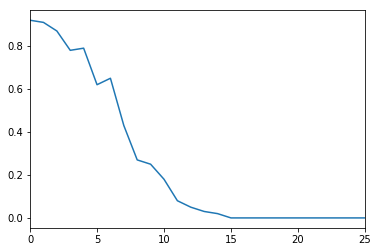

In [20]:
plt.xlim(0,25)
plt.plot(df_mifsud_r1['F_EXP_AMONG_OBS'])

#### Mifsud - Replicate 2

In [21]:
!python analyze_k_interactions_script.py --out-prefix results/mifsud/k_interaction_analysis_mifsud_r2 --interaction-file diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R20.interaction.counts.table.gt1.tsv.gz
df_mifsud_r2 = pd.read_csv('results/mifsud/k_interaction_analysis_mifsud_r2_k_inter.tab', header = (0), sep = '\t')
df_mifsud_r2.head()

[INFO] --out_prefix: results/mifsud/k_interaction_analysis_mifsud_r2
[INFO] --interaction-file: diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R20.interaction.counts.table.gt1.tsv.gz
[INFO] Determining number of k-interactions with zero simple or twisted read pairs in diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R20.interaction.counts.table.gt1.tsv.gz ...
('\t[INFO]', 0, 'interactions processed ...')
('\t[INFO]', 1000000, 'interactions processed ...')
('\t[INFO]', 2000000, 'interactions processed ...')
('\t[INFO]', 3000000, 'interactions processed ...')
('\t[INFO]', 4000000, 'interactions processed ...')
('\t[INFO]', 5000000, 'interactions processed ...')
('\t[INFO]', 6000000, 'interactions processed ...')
('\t[INFO]', 7000000, 'interactions processed ...')
('\t[INFO]', 8000000, 'interactions processed ...')
('\t[INFO]', 9000000, 'interactions processed ...')
('\t[INFO]', 10000000, 'interactions processed ...')
... done.
[INFO] Total number of interactions: 10355044
[IN

,K,N_INTER,N_ZERO_SIMP,N_ZERO_TWIST,N_ZERO_TOT,F_ZERO_TOT,N_ZERO_TOT_EXP,F_EXP_AMONG_OBS,LOG10_P_VAL
0,2,5277680,1363465,1360731,2724196,0.52,2638840,0.97,<323.31
1,3,1463744,198925,198861,397786,0.27,365936,0.92,<323.31
2,4,732942,54511,54024,108535,0.15,91618,0.84,<323.31
3,5,458302,18998,19048,38046,0.08,28644,0.75,<323.31
4,6,316228,7570,7539,15109,0.05,9882,0.65,<323.31


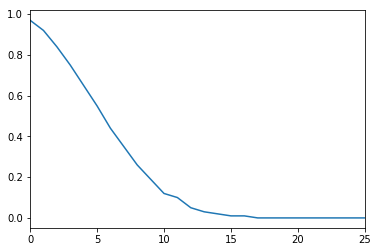

In [23]:
plt.xlim(0,25)
plt.plot(df_mifsud_r2['F_EXP_AMONG_OBS'])

#### Mifsud - Replicate 3

In [25]:
!python analyze_k_interactions_script.py --out-prefix results/mifsud/k_interaction_analysis_mifsud_r3 --interaction-file diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R30.interaction.counts.table.gt1.tsv.gz
df_mifsud_r3 = pd.read_csv('results/mifsud/k_interaction_analysis_mifsud_r3_k_inter.tab', header = (0), sep = '\t')
df_mifsud_r3.head()

[INFO] --out_prefix: results/mifsud/k_interaction_analysis_mifsud_r3
[INFO] --interaction-file: diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R30.interaction.counts.table.gt1.tsv.gz
[INFO] Determining number of k-interactions with zero simple or twisted read pairs in diachrscripts_data/mifsud_2015_hg38/data/gzdir/MIFSUD_R30.interaction.counts.table.gt1.tsv.gz ...
('\t[INFO]', 0, 'interactions processed ...')
('\t[INFO]', 1000000, 'interactions processed ...')
('\t[INFO]', 2000000, 'interactions processed ...')
('\t[INFO]', 3000000, 'interactions processed ...')
('\t[INFO]', 4000000, 'interactions processed ...')
('\t[INFO]', 5000000, 'interactions processed ...')
('\t[INFO]', 6000000, 'interactions processed ...')
... done.
[INFO] Total number of interactions: 6422936
[INFO] Number of trans and short range interactions: 652982 (discarded)
[INFO] Output written to: results/mifsud/k_interaction_analysis_mifsud_r3_k_inter.tab
[INFO] Done.


,K,N_INTER,N_ZERO_SIMP,N_ZERO_TWIST,N_ZERO_TOT,F_ZERO_TOT,N_ZERO_TOT_EXP,F_EXP_AMONG_OBS,LOG10_P_VAL
0,2,3271001,845106,841313,1686419,0.52,1635501,0.97,<323.31
1,3,947257,128843,128003,256846,0.27,236814,0.92,<323.31
2,4,479992,35498,34847,70345,0.15,59999,0.85,<323.31
3,5,293608,11780,11790,23570,0.08,18351,0.78,319.22
4,6,195081,4560,4452,9012,0.05,6096,0.68,275.45


NameError: name 'df_mifsud_r3' is not defined

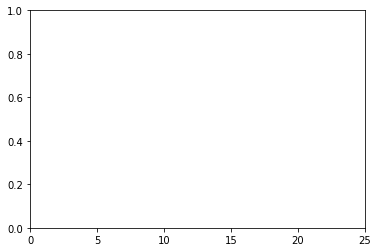

In [24]:
plt.xlim(0,25)
plt.plot(df_mifsud_r3['F_EXP_AMONG_OBS'])

### TSS strand analysis

In order to reroduce the k-interaction alalysis, use the script ```diachrscripts/analyze_tss_strand_distribution_script.py```. This script has the following parameters:

- ```--out-prefix```, e.g. ```results/mifsud/mifsud_r1```
- ```--ref-gene-file```, e.g. ```diachrscripts/data/mifsud/hg38_gopher_refGene.txt.gz```
- ```--interaction-file```, e.g. ```diachrscripts/data/mifsud/gzdir/MIFSUD_R10.interaction.counts.table.gt1.test.tsv.gz```


#### Mifsud - Replicate 1

In [4]:
!python analyze_tss_strand_distribution_script.py --out-prefix mifsud_r1 --ref-gene-file data/mifsud/hg38_gopher_refGene.txt.gz --interaction-file data/mifsud/gzdir/MIFSUD_R10.interaction.counts.table.gt1.test.tsv.gz

[INFO] Parsing refGene annotation file: data/mifsud/hg38_gopher_refGene.txt.gz ...
	[INFO] Found 46945 coordinates that host TSS for 48697 genes.
	[INFO] Found 860 coordinates that host TSS for more than one gene.
	[INFO] Found 4 coordinates that host TSS on different strands.
[INFO] Determining pair category for each interaction in data/mifsud/gzdir/MIFSUD_R10.interaction.counts.table.gt1.test.tsv.gz ...
	[INFO] 0 interactions processed ...
	[INFO] 10000 interactions processed ...
	[INFO] 20000 interactions processed ...
	[INFO] 30000 interactions processed ...
	[INFO] 40000 interactions processed ...
	[INFO] 50000 interactions processed ...
	[INFO] 60000 interactions processed ...
	[INFO] 70000 interactions processed ...
	[INFO] 80000 interactions processed ...
	[INFO] 90000 interactions processed ...
... done.
mifsud_r1
PAIR	SIMPLE	TWISTED	SIMPLE+SIMPLE	UNDIRECTED	INDEFINABLE	SIMPLE	TWISTED	SIMPLE+SIMPLE	UNDIRECTED	INDEFINABLE
'+/-1'	0	0	0	0	0 	0.00	0.00	0.00	0.00	0.00
'd/+'	3	3	6	5

## Expression analysis

Use the script ```diachrscripts/analyze_expression_levels_script.py```.

In [17]:
print("Hallo")

Hallo


In [18]:
!ls data/mifsud/gzdir/MIFSUD_R10.interaction.counts.table.gt1.tsv.gz

data/mifsud/gzdir/MIFSUD_R10.interaction.counts.table.gt1.tsv.gz


In [19]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3

%%HTML

In [18]:
import sys
sys.executable

'/home/peter/anaconda2/envs/diachscripts_env/bin/python'

In [2]:
import numpy